In [1]:
import pandas as pd
import datetime
import geopandas as gpd
import os

In [2]:
drop_list_delitos=['VIOLENCIA FAMILIAR',"PRODUCCIÓN, IMPRESIÓN, ENAJENACIÓN, DISTRIBUCIÓN, ALTERACIÓN O FALSIFICACIÓN DE TÍTULOS AL PORTADOR, DOCUMENTOS DE CRÉDITO PÚBLICOS O VALES DE CANJE", 'FRAUDE' ,'ABUSO DE CONFIANZA','DESPOJO', 'FALSIFICACION DE TITULOS AL PORTADOR Y DOCUMENTOS DE CREDITO PUBLICO','USURPACIÓN DE IDENTIDAD']
mapa_dias= {'Monday':'00_Lunes',
'Tuesday':'01_Martes',
'Wednesday':'02_Miércoles',
'Thursday':'03_Jueves',
'Friday':'04_Viernes',
'Saturday':'05_Sábado',
'Sunday':'06_Domingo'}

In [3]:
def ts_aggregation(df):
  return ((df
  .groupby(['year', 'month'])
  .size()
  .divide(df.shape[0])*100)
  .rename('porc_delitos')
  .to_frame()
  .reset_index()
  .assign(date = lambda x:(x.year.astype(int).astype(str) + x.month.astype(int).astype(str).str.zfill(2) + '01')
          .pipe(pd.to_datetime))
  .drop(columns =['year', 'month'])
  )

def wd_aggregation(df):
  return ((df
  .groupby(['weekday'])
  .size()
  .divide(df.shape[0])*100)
  .rename('porc_delitos')
  .to_frame()
  .reset_index()
         )

def top_n_delitos(df, n ):
    top = df.delito.value_counts(normalize = True).head(n)
    return pd.concat([top, pd.Series(1-top.sum(), index= ['Otros'] )]).rename('porc_delitos').to_frame().reset_index().rename(columns = {'index':'delito'})
def top_n_delitos_sat(df, n ):
    top = (df
           .query("weekday == '05_Sábado'")
           .delito
           .value_counts(normalize = True)
           .head(n))
    return pd.concat([top, pd.Series(1-top.sum(), index= ['Otros'] )]).rename('porc_delitos').to_frame().reset_index().rename(columns = {'index':'delito'})

def hour_aggregation(df):
  return ((df
  .groupby(['hour'])
  .size()
  .divide(df.shape[0])*100)
  .rename('porc_delitos')
  .to_frame()
  .reset_index()
  .assign(hour = lambda x:(x.hour.astype(int).astype(str) + ':00'))
         )

In [4]:
df_downloaded = pd.read_csv('data/carpetas_completa_marzo_2022.csv', parse_dates=['fecha_hechos'])


/home/pepe/miniconda3/envs/desarollo_plataforma/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
places = gpd.read_file('data/places.geojson')[['nombre', 'geometry']]

In [6]:
df=(df_downloaded
    #.sample(1000)
    .assign(fecha_hechos = lambda x: (x
                                    .fecha_hechos
                                    .str.replace("222-", '2022-')
                                    .str.replace('02022-', '2022-')
                                    .pipe(pd.to_datetime,
                                          format='%Y-%m-%d %H:%M:%S')
                                   ),
          weekday= lambda x: x.fecha_hechos.dt.strftime('%A').map(mapa_dias),
          hour = lambda x: x.fecha_hechos.dt.hour,
          month = lambda x: x.fecha_hechos.dt.month,
          year = lambda x: x.fecha_hechos.dt.year,
          geometry = lambda x: gpd.points_from_xy(x= x.longitud, y = x.latitud)
         )
    .pipe(gpd.GeoDataFrame)
    
    .query('year == 2019 |year == 2020 | year == 2021 | year ==2022')
   .query("categoria_delito!='HECHO NO DELICTIVO'")
   .query(f"~delito.str.contains('{'|'.join(drop_list_delitos)}')"))

df=df.loc[df.geometry.is_valid]

In [7]:
df = gpd.sjoin(df, places)

/home/pepe/miniconda3/envs/desarollo_plataforma/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  """Entry point for launching an IPython kernel.


In [8]:
! rm -r data/bmks

In [9]:
! mkdir data/bmks

In [10]:
ts_aggregation(df).to_csv('data/bmks/ts_aggregation.csv', index= False)
hour_aggregation(df).to_csv('data/bmks/hour_aggregation.csv', index= False)
wd_aggregation(df).to_csv('data/bmks/wd_aggregation.csv', index= False)
top_n_delitos(df,  15).to_csv('data/bmks/top_n_delitos.csv', index= False)
top_n_delitos_sat(df, 15).to_csv('data/bmks/top_n_delitos_sat.csv', index= False)
(df
 .nombre
 .value_counts()
 .rename('n_delitos')
 .to_frame()
 .reset_index()
 .rename(columns = {'index':'lugar'})
).to_csv('data/bmks/count_delitos_by_lugar.csv', index= False)


In [11]:
# By place
for names, group in df.groupby('nombre'):
    try :
        os.mkdir(f'data/by_place')
    except:
        print('dir exists')
    for names, group in df.groupby('nombre'): 
        try :
            os.mkdir(f'data/by_place/{names}')
        except:
            print('dir exists')
        ts_aggregation(group).to_csv(f'data/by_place/{names}/ts_aggregation.csv', index= False)
        hour_aggregation(group).to_csv(f'data/by_place/{names}/hour_aggregation.csv', index= False)
        wd_aggregation(group).to_csv(f'data/by_place/{names}/wd_aggregation.csv', index= False)
        top_n_delitos(group,  15).to_csv(f'data/by_place/{names}/top_n_delitos.csv', index= False)
        top_n_delitos_sat(group, 15).to_csv(f'data/by_place/{names}/top_n_delitos_sat.csv', index= False)

dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists

dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists
dir exists


In [12]:
df[['nombre', "geometry", 'delito']].to_file('data/points_for_map.geojson', driver = 'GeoJSON')

<AxesSubplot:>

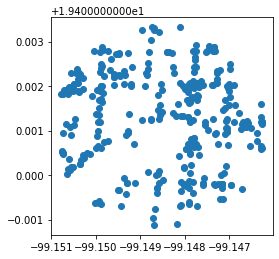

In [15]:
df[['nombre', "geometry", 'delito']].loc[df['nombre']=='Zona Hyadi, Conquista Deneb, Las Américas'].plot()